# Impact of confound removal strategies on functional connectivity generated from fMRIprep preprocessed data 

Authors

## Introduction

- Existing literature on confounds has compared the denoising strategies extensively
- Popularity of minimally preprocessing pipeline:
    - Pros: Freedom to experiment with impact of various factors for method development
    - Cons: difficult for end users with less method-focused research to do the downstream analysis right
- fMRIprep provides minimal preprocessing pipeline with lots of confounds with the minimally processed data
- It’s difficult to navigate the confounds and implement the sensible subset of variables in downstream analysis
- We provide solution and benchmark using fMRIPrep outputs on various modern connectomes

## Methods

- Dataset: pixar movie watching developmental dataset
- fMRIprep version
- Nilearn code implementation
- Atlases used
- Metric: 
    - correlation of connectivity edges with mean FD

## Results

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path_root = Path.cwd().parents[0] / "inputs"
file_qcfc = "dataset-ds000288_atlas-schaefer7networks_nroi-400_desc-covqcfc.tsv"
file_dist = path_root / "atlas" / "schaefer7networks" / "atlas-schaefer7networks_nroi-400_desc-distance.tsv"

pairwise_distance = pd.read_csv(file_dist, sep='\t')
qcfc = pd.read_csv(path_root / file_qcfc, sep='\t', index_col=0)
sig_per_edge = qcfc.filter(regex="pvalue")
sig_per_edge.columns = [col.split('_')[0] for col in sig_per_edge.columns]
metric_per_edge = qcfc.filter(regex="correlation")
metric_per_edge.columns = [col.split('_')[0] for col in metric_per_edge.columns]


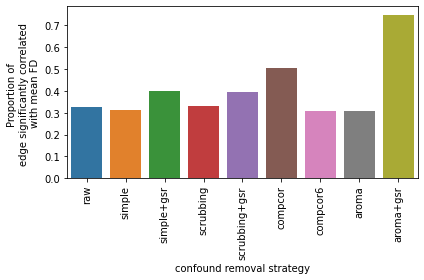

In [3]:
# separate p-value and correlation stats
# plotting test
ax = sns.barplot(data=(sig_per_edge<0.05), ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(ylabel="Proportion of \nedge significantly correlated \nwith mean FD",
        xlabel="confound removal strategy")
plt.tight_layout()

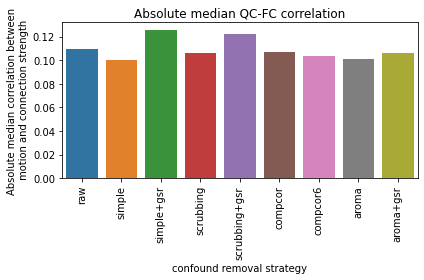

In [4]:
absolute_median = (metric_per_edge - metric_per_edge.median()).abs().median()
absolute_median = pd.DataFrame(absolute_median, index=metric_per_edge.columns)
ax = sns.barplot(data=absolute_median.T, ci=None)
ax.set_title("Absolute median QC-FC correlation")

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(ylabel="Absolute median correlation between\n motion and connection strength",
        xlabel="confound removal strategy")
plt.tight_layout()

/tmp/ipykernel_26039/800627245.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  long_qcfc["col"] = np.tile(np.hstack((np.ones(metric_per_edge.shape[0]) * i for i in range(3))), 3)


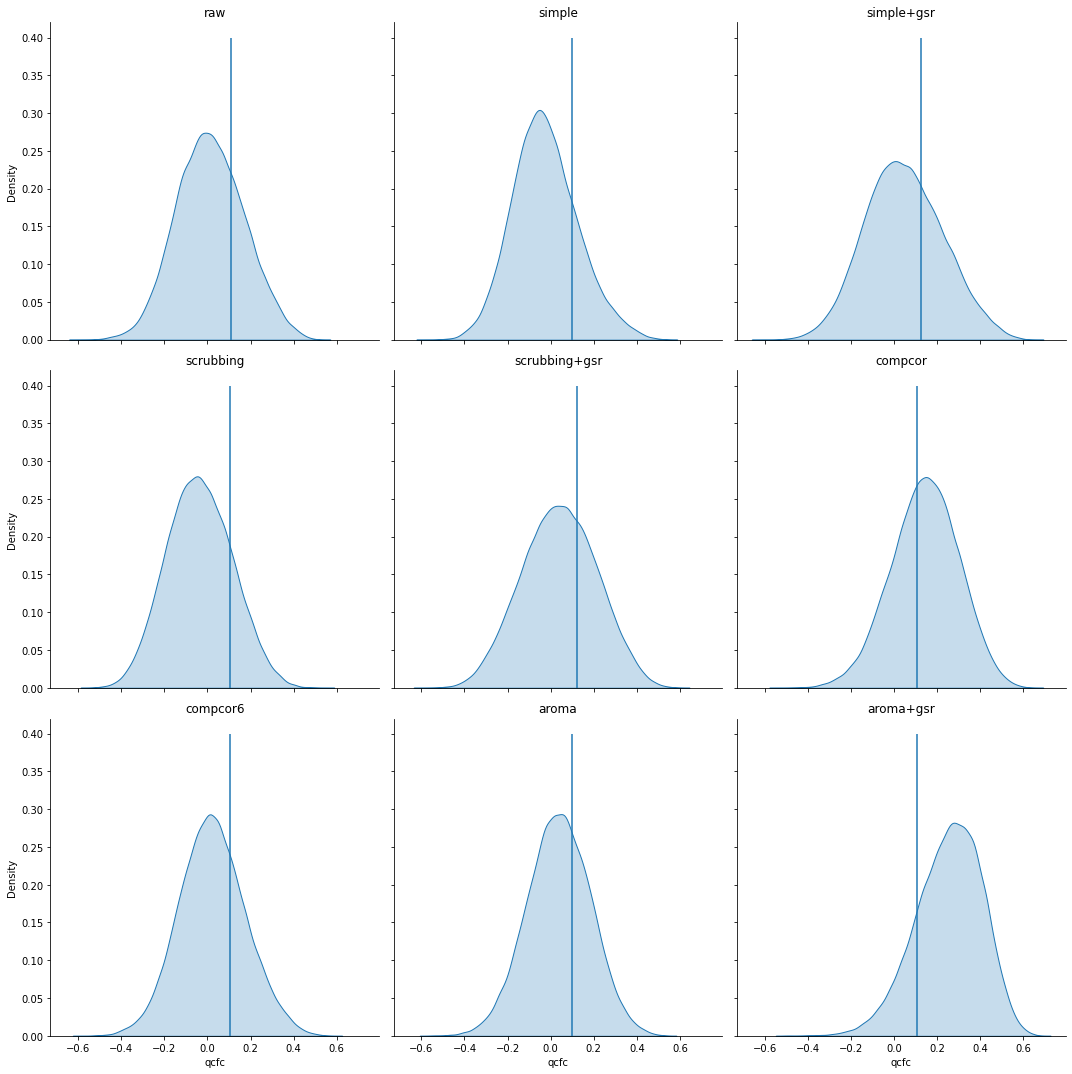

In [5]:
long_qcfc = metric_per_edge.melt()
long_qcfc.columns = ["Strategy", "qcfc"]
long_qcfc["row"] = np.hstack((np.ones(int(long_qcfc.shape[0] / 3)), 
                              np.ones(int(long_qcfc.shape[0] / 3))* 2,
                              np.ones(int(long_qcfc.shape[0] / 3))* 3)
                             )
long_qcfc["col"] = np.tile(np.hstack((np.ones(metric_per_edge.shape[0]) * i for i in range(3))), 3)

def draw_absolute_median(data, **kws):
    ax = plt.gca()
    mad = (data['qcfc'] - data['qcfc'].median()).abs().median()
    ax.vlines(mad, ymin=0, ymax=0.4)


g = sns.displot(
    long_qcfc, x="qcfc", col="col", row="row", kind='kde', fill=True
)
g.set(ylabel="Density")
g.map_dataframe(draw_absolute_median)

for i, name in zip(range(9), metric_per_edge.columns):
    axis_i = int(i / 3)
    axis_j = i % 3
    g.facet_axis(axis_i, axis_j).set(title=name)
    if axis_i == 1:
        g.facet_axis(axis_i, axis_j).set(xlabel="Pearson\'s correlation: \nmean FD and\nconnectome edges")

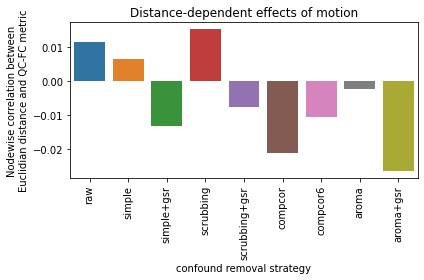

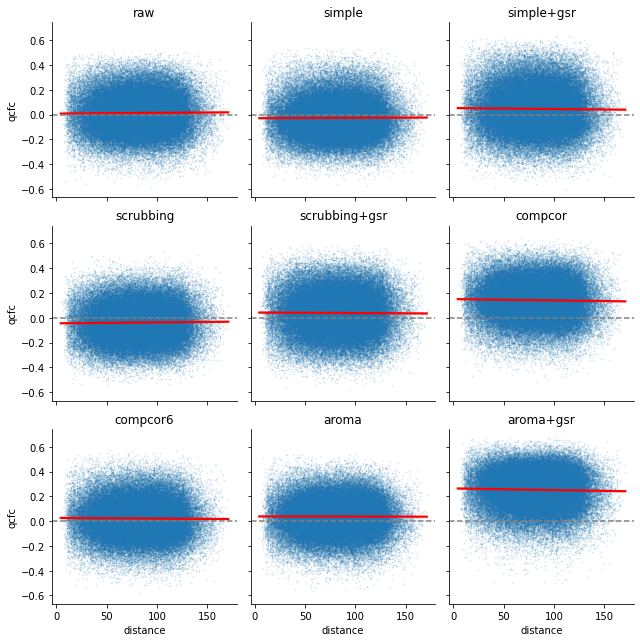

In [6]:
# separate p-value and correlation stats
# plotting test
corr_distance = np.corrcoef(pairwise_distance.iloc[:, -1], metric_per_edge.T)[1:, 0]
corr_distance = pd.DataFrame(corr_distance, index=metric_per_edge.columns)
ax = sns.barplot(data=corr_distance.T, ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Distance-dependent effects of motion")
ax.set(ylabel="Nodewise correlation between\nEuclidian distance and QC-FC metric",
        xlabel="confound removal strategy")
plt.tight_layout()


from scipy.stats import gaussian_kde

long_qcfc['distance'] = np.tile(pairwise_distance.iloc[:, -1].values, 9)
# Calculate the point density
xy = np.vstack([long_qcfc['distance'], long_qcfc['qcfc']])
g = sns.FacetGrid(long_qcfc, col="col", row="row")
g.map(sns.regplot, 'distance', 'qcfc', fit_reg=True, ci=None, 
      line_kws={'color': 'red'}, scatter_kws={'s': 0.5, 'alpha': 0.15,})
g.refline(y=0)
for i, name in zip(range(9), metric_per_edge.columns):
    axis_i = int(i / 3)
    axis_j = i % 3
    g.facet_axis(axis_i, axis_j).set(title=name)

## Conclusions

## References